## Механизмы распределения ресурсов нисходящего кадра в телекоммуникационных сетях

Параметры по варианту: <br>
* Модель распределения: **Окумура-Хата, small city**
* $R$, км: **1**
* $P_{TX}$, Вт: **10**
* $f_0$, МГц: **900**
* $\triangle f$, МГц: **3**
* $k_n$: **2**

Используемые библиотеки

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Размещение N абонентов в радиусе R

Формулы для равномерного размещения абонентов в круге радиуса R. Используем полярные координаты:
$$ R = \sqrt{uniform(0, R^2, N)} $$
$$ angle = uniform(0, 2*\pi, N) $$

Причина почему был выбран именно этот метод - [Источник](https://habr.com/ru/articles/583838/)

In [3]:
np.random.seed(150)

# Радиус действия базовой станции
r = 1


# Количество абонентов


N = 1024


# Расстояние до базовой станции


create_distance = lambda N: np.sqrt(np.random.uniform(0, r**2, N))


distance = create_distance(N)


# Угол размещения абонента вокруг станции


create_angle = lambda N: np.random.uniform(0, 2 * np.pi, N)


angle = create_angle(N)


theta = np.linspace(0, 2 * np.pi, 100)

Для перехода к евклидовым координатам используем следующие преобразования:
$$ x = r * cos(angle) $$
$$ y = r * sin(angle) $$

In [4]:
# Для абонентов
x = distance * np.cos(angle)
y = distance * np.sin(angle)

# Для окружности
x_r, y_r = r * np.cos(theta), r * np.sin(theta)

Визуализируем полученный результат на графике:

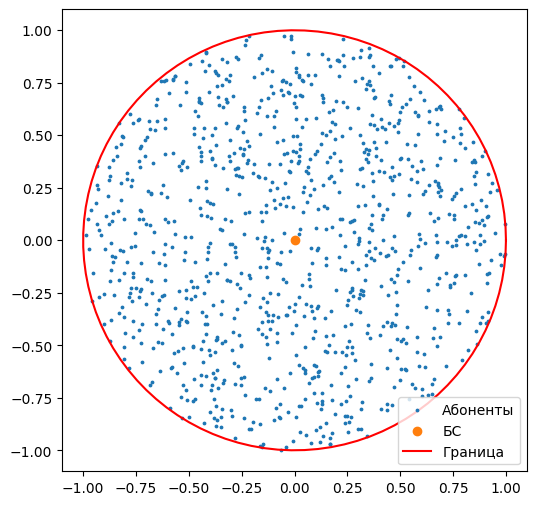

In [5]:
plt.figure(figsize=(6, 6))
plt.scatter(x, y, label="Абоненты", s=3)
plt.scatter(0, 0, label="БС")
plt.plot(x_r, y_r, label="Граница", color="r")
plt.legend()
plt.show()

### Расчёт величин максимально достижимых скоростей

Для сформированных местоположений абонентов требуется рассчитать величины максимально достижимых скоростей $C_1, ..., C_N$ по следующей формуле:
$$ C_i = \triangle f \log_2 (1 + SNR_i) $$
В данном случае поскольку значение $\triangle f$ уже известно, то необходимо определить второй параметр. Он высчитывается по формуле:
$$ SNR = \frac{P_{RX}}{P_N} $$
В свою очередь $ P_N $ определяется по следующей формуле:
$$ P_N = \triangle f \cdot T \cdot k \cdot k_N$$
В данной формуле: $T$ - абсолютная температура (К), $k$ - постоянная Больцмана, $k_N$ - коэффициент теплового шума приемника <br>

Возвращаясь к формуле подсчета $SNR$, величина $P_{RX}$ находится по следующей формуле:
$$P_{RX} = \frac{P_{TX}}{L}$$
В данной формуле остаётся неизвестна величина $L$, которую можно рассчитать несколькими способами. Одним из возможных подходов является модель Окамура-Хата, основанная на аналитической аппроксимации результатов практических измерений. Таким образом $L$ рассчитывается следующим образом:
$$ 10 \lg L = 46.3 + 33.9\cdot\lg f_0 - 13.82\cdot\lg h_{БС} - \alpha(h_{RX}) + [44.9 - 6.55\cdot\lg h_{RX}]\lg d + S $$
В данной формуле изначально даны $f_0$ и $S$. Величина $\alpha(h_{RX})$ высчитывается как:
$$ \alpha(h_{RX}) = (1.1 \cdot \lg f_0 - 0.7)h_{RX} - (1.56 \cdot \lg f_0 - 0.8) $$

Для начала определим все необходимые переменные:

In [6]:
# Полоса пропускания канала связи (Гц)
delta_f = 3 * 10**6

# Постоянная Больцмана (Дж/К)
k = 1.38 * 10 ** (-23)

# Коэффициент теплового шума приемника
k_n = 2

# Излучаемая мощность базовой станции (Вт)
p_tx = 10

# Частота сигнала (МГц)
f_0 = 900

# Абсолютная температура (К)
t = 300

# Высота базовой станции (м)
h_bs = 30

# Высота точки приема (м)
h_rx = 2

Далее, по очереди определим все значения по формулам выше:

In [7]:
alpha_h_rx = (1.1 * np.log10(f_0) - 0.7) * h_rx - (1.56 * np.log10(f_0) - 0.8)

# Потери мощности сигнала (lg(L))
lg_l = (
    46.3
    + 33.9 * np.log10(f_0)
    - 13.82 * np.log10(h_bs)
    - alpha_h_rx
    + (44.9 - 6.55 * np.log10(h_rx)) * np.log10(distance)
) / 10

# Потери мощности сигнала (L)
L = 10 ** (lg_l)

# Принятая мощность сигнала (P_rx) (Вт)
P_rx = p_tx / L

# Мощность теплового шума (P_n) (Вт)
P_n = delta_f * t * k * k_n

# Соотношение сигнал/шум (SNR)
SNR = P_rx / P_n

# Максимальная пропускная способность канала (бит/с)
C = delta_f * np.log2(1 + SNR)

Посмотрим на максимальное значение пропускной способности среди имеющихся абонентов и посмотрим, насколько далеко данный абонент находится от БС

In [8]:
max_c_i = np.argmax(C)

print(
    f"Максимальная скорость: {C[max_c_i]/(10**6):.2f} Мбит/с\nДостигается на расстоянии: {distance[max_c_i]*(10**3):.2f} м."
)
print(
    f"Ближайший абонент находится на расстоянии {np.min(distance)*(10**3):.2f} м. от БС"
)

Максимальная скорость: 83.08 Мбит/с
Достигается на расстоянии: 35.84 м.
Ближайший абонент находится на расстоянии 35.84 м. от БС


Получается, что самый ближайший абонент имеет самую высокую потенциальную скорость передачи, что логично

### Алгоритм распределения ресурсов - Equal Blind

Поскольку мощность БС ограничена, а абонентов много, то максимальная пропускная способность является лишь гипотетическим пределом. Введём коэффициент $\alpha_{i}$, показывающий какая доля ресурсов выделяется $i$-ому абонентов. В таком случае результирующая скорость для $i$-ого абонента выглядит следующим образом:
$$ D_i = \alpha_{i} C_i $$

В связи с этим существует 3 алгоритма распределения ресурсов. Первый алгоритм обеспечивает равные скорости между всеми абонентами (Equal Blind):
$$ D_i = D_j = D $$
Однако остаётся вопрос, как выразить коэффициент $\alpha_{i}$. Для этого существует формула:
$$ \alpha_{i} = \frac{1}{C_i} \bigg( \sum_{i=1}^N C_i^{-1} \bigg)^{-1} $$
Из данного уравнения следует, что скорость $i$-ого абонента может быть выражена как:
$$ D_i = \bigg( \sum_{i=1}^N C_i^{-1} \bigg)^{-1} $$

Вычислим скорости передачи данных, если будет использоваться данный алгоритм распределения:

In [9]:
D = [(np.sum(C ** (-1))) ** (-1) for _ in range(N)]

Также, определим величины суммарной скорости передачи $D_{\sum}$, средней скорости $\overline{D}$, а также средней минимальной скорости среди всех абонентов $D_{\min}$

In [10]:
print(
    f"Суммарная скорость передачи: {np.sum(D):.2f} бит/с\nСредняя скорость: {np.mean(D):.2f} бит/с\nМинимальная скорость: {np.min(D):.2f} бит/с"
)

Суммарная скорость передачи: 28647071.32 бит/с
Средняя скорость: 27975.66 бит/с
Минимальная скорость: 27975.66 бит/с


### Алгоритм распределения ресурсов - Maximum Throughput

Данный алгоритм максимизирует суммарную скорость передачи:
$$D_{\sum} \rightarrow \max$$
В данном случае коэффициенты $\alpha_{i}$ будут определяться следующим образом:
$$\begin{cases}
   x = \argmax C_i \\
   \sum \alpha_{i} = 1
 \end{cases}
 \Longrightarrow \alpha_{x} = 1$$

In [11]:
D = [0 if i != np.argmax(C) else C[i] for i in range(N)]
print(
    f"Суммарная скорость передачи: {np.sum(D):.2f} бит/с\nСредняя скорость: {np.mean(D):.2f} бит/с\nМинимальная скорость: {np.min(D)} бит/с"
)

Суммарная скорость передачи: 83076552.70 бит/с
Средняя скорость: 81129.45 бит/с
Минимальная скорость: 0.0 бит/с


### Алгоритм распределения ресурсов - Proportional Fair

В отличии от предыдущих двух алгоритмов, данный метод выделяет равные доли ресурсов всем абонентам:
$$ \alpha_i = \frac{1}{N} \Rightarrow D_i \frac{C_i}{N} $$
Таким образом формула для подсчета суммарной скорости передачи выглядит следующим образом:
$$ D_{\sum} = \frac{1}{N} \sum_{i=1}^N C_i $$

In [12]:
D = C / N
print(
    f"Суммарная скорость передачи: {np.sum(D):.2f} бит/с\nСредняя скорость: {np.mean(D):.2f} бит/с\nМинимальная скорость: {np.min(D):.2f} бит/с"
)

Суммарная скорость передачи: 30542700.44 бит/с
Средняя скорость: 29826.86 бит/с
Минимальная скорость: 20770.07 бит/с


### Построение графиков

Наконец, необходимо повторяя случайное размещение абонентов $M$ раз (min 100), построить графики зависимости оценок $M[D_{\sum}]$, $M[\overline{D}]$ и $M[D_{\min}]$ от числа абонентов в сети $N$. Количество абонентов принимать равными $N = 1,2,4,8,..., 64$.

Для начала создадим функцию подсчета скоростей в зависимости от количества абонентов:

In [13]:
def calculate_Ds(N: int, accuracy: int, dtype: str):
    # Определяем массивы вычисляемых значений
    print(f"{dtype = }, {N = }")
    equal = []
    maxs = []
    proportion = []
    for _ in range(accuracy):
        # Определяем основные параметры
        distance = create_distance(N)
        lg_l = (
            46.3
            + 33.9 * np.log10(f_0)
            - 13.82 * np.log10(h_bs)
            - alpha_h_rx
            + (44.9 - 6.55 * np.log10(h_rx)) * np.log10(distance)
        ) / 10
        L = 10 ** (lg_l)
        P_rx = p_tx / L
        P_n = delta_f * t * k * k_n
        SNR = P_rx / P_n
        C = delta_f * np.log2(1 + SNR)

        # Создаём массивы D
        D1 = [(np.sum(C ** (-1))) ** (-1) for _ in range(N)]
        D2 = [0 if i != np.argmax(C) else C[i] for i in range(N)]
        D3 = C / N

        # В зависимости от функции записываем результат
        match dtype:
            case "sum":
                equal.append(np.sum(D1))
                maxs.append(np.sum(D2))
                proportion.append(np.sum(D3))
            case "mean":
                equal.append(np.mean(D1))
                maxs.append(np.mean(D2))
                proportion.append(np.mean(D3))
            case "min":
                equal.append(np.min(D1))
                maxs.append(np.min(D2))
                proportion.append(np.min(D3))

    return np.mean(equal), np.mean(maxs), np.mean(proportion)

Далее введём количество абонентов и получим массивы скоростей для каждого из алгоритмов распределения:

In [19]:
# Количество абонентов
N = np.logspace(0, 6, base=2, num=7, dtype=np.int16)

# Точность вычислений
accuracy = 1000

# Массивы для графиков
D_equals, D_maxs, D_proportion = {}, {}, {}

# Возможные типы алгоритмов
algs = ["sum", "mean", "min"]

for alg in algs:
    temp_results = np.array([calculate_Ds(i, accuracy, alg) for i in N]).T
    D_equals[alg] = temp_results[0]
    D_maxs[alg] = temp_results[1]
    D_proportion[alg] = temp_results[2]

dtype = 'sum', N = 1
dtype = 'sum', N = 2
dtype = 'sum', N = 4
dtype = 'sum', N = 8
dtype = 'sum', N = 16
dtype = 'sum', N = 32
dtype = 'sum', N = 64
dtype = 'mean', N = 1
dtype = 'mean', N = 2
dtype = 'mean', N = 4
dtype = 'mean', N = 8
dtype = 'mean', N = 16
dtype = 'mean', N = 32
dtype = 'mean', N = 64
dtype = 'min', N = 1
dtype = 'min', N = 2
dtype = 'min', N = 4
dtype = 'min', N = 8
dtype = 'min', N = 16
dtype = 'min', N = 32
dtype = 'min', N = 64


Для визуализации полученных данных создадим следующую функцию:

In [20]:
def create_plot(N, equals, maxs, proportion, ylabel: str, title: str) -> None:
    plt.figure(figsize=(5, 5))
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.plot(N, equals, label="Equals Blinds")
    plt.plot(N, maxs, label="Maximum Throughput")
    plt.plot(N, proportion, label="Proportion Fair")
    plt.xlabel("Количество абонентов")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

А затем, при помощи данной функции визуализируем все полученные данные:

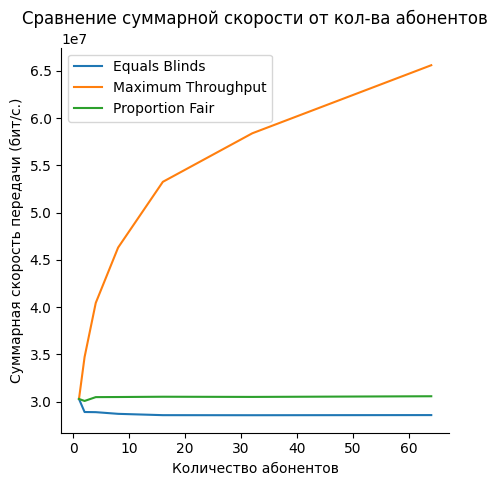

In [21]:
create_plot(
    N,
    D_equals["sum"],
    D_maxs["sum"],
    D_proportion["sum"],
    "Суммарная скорость передачи (бит/с.)",
    "Сравнение суммарной скорости от кол-ва абонентов",
)

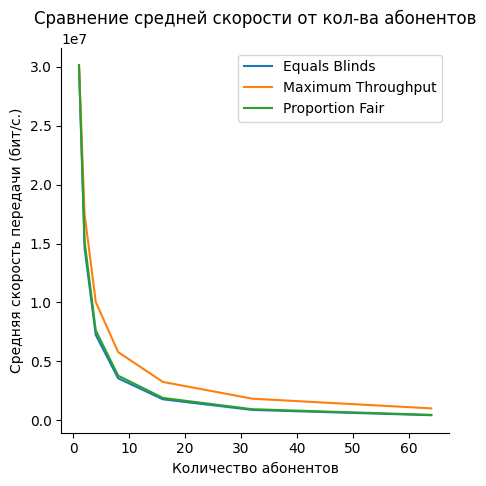

In [22]:
create_plot(
    N,
    D_equals["mean"],
    D_maxs["mean"],
    D_proportion["mean"],
    "Средняя скорость передачи (бит/с.)",
    "Сравнение средней скорости от кол-ва абонентов",
)

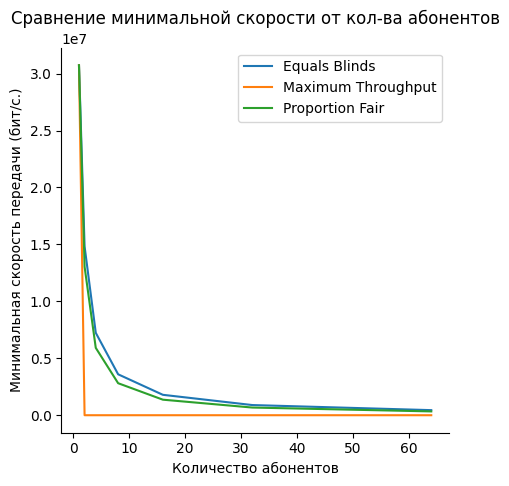

In [23]:
create_plot(
    N,
    D_equals["min"],
    D_maxs["min"],
    D_proportion["min"],
    "Минимальная скорость передачи (бит/с.)",
    "Сравнение минимальной скорости от кол-ва абонентов",
)